# Goal
- implement epsilon greedy algorithms for suggesting top 5 movie for each user 
- reward is the overlap between suggested movie and the 5 most like movie in the focal group
- arm is movies with greater than 200 ratings
- div the dataset with 
‣ Male, Young (age < 30)
‣ Male, Adult (age ≥ 30)
‣ Female, Young (age < 30)
‣ Female, Adult (age ≥ 30) 

## Potential questions
- reward choice: binary or use the actual rating 


# load data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
user_info = pd.read_table('u.user', header=None,names=['user_id', 'age','gender','occupation','zip_code'],sep='|')
user_rating = pd.read_table('u.data', header=None,names=['user_id','item_id','rating','timestamp'])

In [3]:
user_rating_with_info = pd.merge(user_rating, user_info, left_on='user_id', right_on='user_id')
user_rating_with_info.head()

,user_id,item_id,rating,timestamp,age,gender,occupation,zip_code
0,196,242,3,881250949,49,M,writer,55105
1,196,393,4,881251863,49,M,writer,55105
2,196,381,4,881251728,49,M,writer,55105
3,196,251,3,881251274,49,M,writer,55105
4,196,655,5,881251793,49,M,writer,55105


## get movies with more than 200 ratings

In [4]:
movie_rating_count = user_rating.groupby('item_id')['rating'].count()
movie_with_gt_200_rating = movie_rating_count[movie_rating_count > 200]
movie_with_gt_200_rating.index


Int64Index([  1,   4,   7,   8,   9,  11,  12,  15,  22,  25,
            ...
            515, 546, 568, 588, 597, 603, 655, 678, 742, 748],
           dtype='int64', name='item_id', length=117)

In [18]:
movie_with_gt_200_rating

item_id
1      452
4      209
7      392
8      219
9      299
      ... 
603    209
655    227
678    219
742    267
748    316
Name: rating, Length: 117, dtype: int64

### filter full dataset with this movie list


In [6]:

user_rating_with_info = user_rating_with_info[user_rating_with_info['item_id'].isin(movie_with_gt_200_rating.index)]
user_rating_with_info['like'] = user_rating_with_info['rating'].map(lambda x : 1 if x >= 4 else 0)


C:\Users\doraz\AppData\Local\Temp\ipykernel_7140\2349021141.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_rating_with_info['like'] = user_rating_with_info['rating'].map(lambda x : 1 if x >= 4 else 0)


In [7]:
user_rating_with_info

,user_id,item_id,rating,timestamp,age,gender,occupation,zip_code,like
4,196,655,5,881251793,49,M,writer,55105,1
7,196,238,4,881251820,49,M,writer,55105,1
9,196,111,4,881251793,49,M,writer,55105,1
11,196,25,4,881251955,49,M,writer,55105,1
12,196,286,5,881250949,49,M,writer,55105,1
...,...,...,...,...,...,...,...,...,...
99989,941,222,2,875049038,20,M,student,97229,0
99994,941,300,4,875048495,20,M,student,97229,1
99996,941,273,3,875049038,20,M,student,97229,0
99997,941,1,5,875049144,20,M,student,97229,1


## split user data

In [8]:
male_young = user_rating_with_info[(user_rating_with_info['age'] < 30) & (user_rating_with_info['gender'] == 'M')]
male_adult = user_rating_with_info[(user_rating_with_info['age'] >= 30) & (user_rating_with_info['gender'] == 'M')]
female_young = user_rating_with_info[(user_rating_with_info['age'] < 30) & (user_rating_with_info['gender'] == 'F')]
female_adult = user_rating_with_info[(user_rating_with_info['age'] >= 30) & (user_rating_with_info['gender'] == 'F')]

In [9]:
print(len(male_young))
print(len(male_adult))
print(len(female_young))
print(len(female_adult))

11838
13250
3935
4457


## get top 5 most like movie for each focal group

In [8]:
#get mean for movie in each focal group and get highest 5

male_young_top5_movie_rating = male_young.groupby('item_id')['rating'].mean().nlargest(5).index
male_adult_top5_movie_rating = male_adult.groupby('item_id')['rating'].mean().nlargest(5).index
female_young_top5_movie_rating = female_young.groupby('item_id')['rating'].mean().nlargest(5).index
female_adult_top5_movie_rating = female_adult.groupby('item_id')['rating'].mean().nlargest(5).index

male_young_top5_movie_like = male_young.groupby('item_id')['like'].sum().nlargest(5).index
male_adult_top5_movie_like = male_adult.groupby('item_id')['like'].sum().nlargest(5).index
female_young_top5_movie_like = female_young.groupby('item_id')['like'].sum().nlargest(5).index
female_adult_top5_movie_like = female_adult.groupby('item_id')['like'].sum().nlargest(5).index



In [54]:
male_young_top5_movie_rating

Int64Index([272, 223, 316, 478, 315], dtype='int64', name='item_id')

In [55]:
male_young_top5_movie_like

Int64Index([222, 268, 300, 216, 298], dtype='int64', name='item_id')

# construct MAB

In [9]:
from tqdm import tqdm

class ReplaySimulator(object):
    def __init__(self, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name,reference_list_rating,reference_list_like, n_iterations=1, random_seed=1):
        # Set the random seed for reproducibility
        

        # Store input data and parameters
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name
        self.reference_list_rating = reference_list_rating
        self.reference_list_like = reference_list_like

        # Number of visits to replay/simulate
        self.n_visits = n_visits

        # Number of runs to average over
        self.n_iterations = n_iterations

        # Items under test
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)

        # Visitors in the historical reward_history
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)

    def reset(self):
        # Initialize counters for item samples and rewards
        self.n_item_samples = np.zeros(self.n_items)
        self.n_item_rewards = np.zeros(self.n_items)

    def replay(self):
        # Store simulation results
        results = []

        for iteration in range(0, self.n_iterations):
            # Reset counters for each iteration
            self.reset()

            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in  tqdm(range(0, self.n_visits)):
                found_match = False
                while not found_match:
                    # Choose a random visitor
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]

                    # Select an item to offer the visitor
                    item_idx_list = self.select_item()
                    item_id_list = self.items[item_idx_list]

                    # Check if this interaction exists in the history
                    reward = self.reward_history[
                                (self.reward_history[self.visitor_col_name] == visitor_id) &
                                (self.reward_history[self.item_col_name].isin(item_id_list))
                                ][[self.item_col_name, self.reward_col_name]]
                    found_match = reward.shape[0] >= 5

                #update rewards
                reward_value = sum(reward[self.reward_col_name]) 
                # print("user rating: ", reward)
                # print("drawed arm",item_id_list)

                #for each movie in drawed arm, update the reward individually 
                for item_idx in item_idx_list:
                    item_reward_value = reward[(reward[self.item_col_name] == self.items[item_idx])][self.reward_col_name].iloc[0]
                    self.record_result(item_idx, item_reward_value)
                

                # Record metrics
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards * 1. / (visit + 1)
                

                result = {}
                result['iteration'] = iteration
                result['visit'] = visit
                result['item_id_list'] = item_id_list
                result['visitor_id'] = visitor_id
                result['reward'] = reward_value
                result['total_reward'] = total_rewards
                result['fraction_relevant'] = total_rewards * 1. / (visit + 1)
                result['percentage_overlap_rating'] = float(len(set(item_id_list) & set(self.reference_list_rating))) / 5 *100
                result['percentage_overlap_like'] = float(len(set(item_id_list) & set(self.reference_list_like))) / 5 *100

                results.append(result)
                
            # print([i for i in self.n_item_rewards])

        return results

    def select_item(self):
        # This method selects an item randomly
        return [np.random.randint(self.n_items) for i in range(5)]

    def record_result(self, item_idx, reward):
        # This method records the result of an interaction and updates item statistics

        # Update the number of times the item has been sampled
        self.n_item_samples[item_idx] += 1

        # Update the fraction of time the item has resulted in a reward
        alpha = 1. / self.n_item_samples[item_idx]
        self.n_item_rewards[item_idx] += alpha * (reward - self.n_item_rewards[item_idx])

class EpsilonGreedyReplayer(ReplaySimulator):
    '''
    A class to provide functionality for simulating the replayer method on an epsilon-Greedy bandit algorithm.
    '''

    def __init__(self, epsilon, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name,reference_list_rating,reference_list_like, n_iterations=1):
        super(EpsilonGreedyReplayer, self).__init__(n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name,reference_list_rating,reference_list_like, n_iterations)
    
        # parameter to control exploration vs exploitation
        self.epsilon = epsilon
    
    def select_item(self):
        
        # decide to explore or exploit
        if np.random.uniform() < self.epsilon: # explore
            item_id = super(EpsilonGreedyReplayer, self).select_item()
            
        else: # exploit
            item_id = self.n_item_rewards.argsort()[-5:][::-1]
            
        return item_id


In [1]:
#maximum number of row in csv is 6w
n_visits = 4000
n_iterations = 3



reward_history_list = [male_young,male_adult,female_young,female_adult]
reward_reference_list_rating = [male_young_top5_movie_rating,male_adult_top5_movie_rating,female_young_top5_movie_rating,female_adult_top5_movie_rating]
reward_reference_list_like = [male_young_top5_movie_like,male_adult_top5_movie_like,female_young_top5_movie_like,female_adult_top5_movie_like]
reward_history_list_name = ['male_young','male_adult','female_young','female_adult']
item_col_name = 'item_id'
visitor_col_name = 'user_id'
reward_col_name = 'like'
epsilon_values = [0.7,0.5,0.3,0.2,0.1]


NameError: name 'male_young' is not defined

In [72]:

for i in range(len(reward_history_list)):
    reward_history = reward_history_list[i]
    for epsilon in epsilon_values:
        print(reward_history_list_name[i],epsilon)
        results = EpsilonGreedyReplayer(epsilon, n_visits, reward_history,
                                           item_col_name, visitor_col_name, reward_col_name,reward_reference_list_rating[i],reward_reference_list_like[i],
                                           n_iterations=n_iterations).replay()
        results_df = pd.DataFrame(results)
        results_df.to_csv(f'output_MAB/{reward_history_list_name[i]}_e={epsilon}.csv')


male_young 0.7


100%|██████████| 4000/4000 [46:41<00:00,  1.43it/s]  


male_young 0.5


100%|██████████| 4000/4000 [1:10:04<00:00,  1.05s/it]


male_young 0.3


100%|██████████| 4000/4000 [2:03:19<00:00,  1.85s/it]  


male_young 0.2


100%|██████████| 4000/4000 [1:46:11<00:00,  1.59s/it]  


male_young 0.1


100%|██████████| 4000/4000 [5:16:30<00:00,  4.75s/it]   


male_adult 0.7


100%|██████████| 4000/4000 [29:50<00:00,  2.23it/s] 


male_adult 0.5


  3%|▎         | 126/4000 [01:40<40:19,  1.60it/s] 

# Evaluation

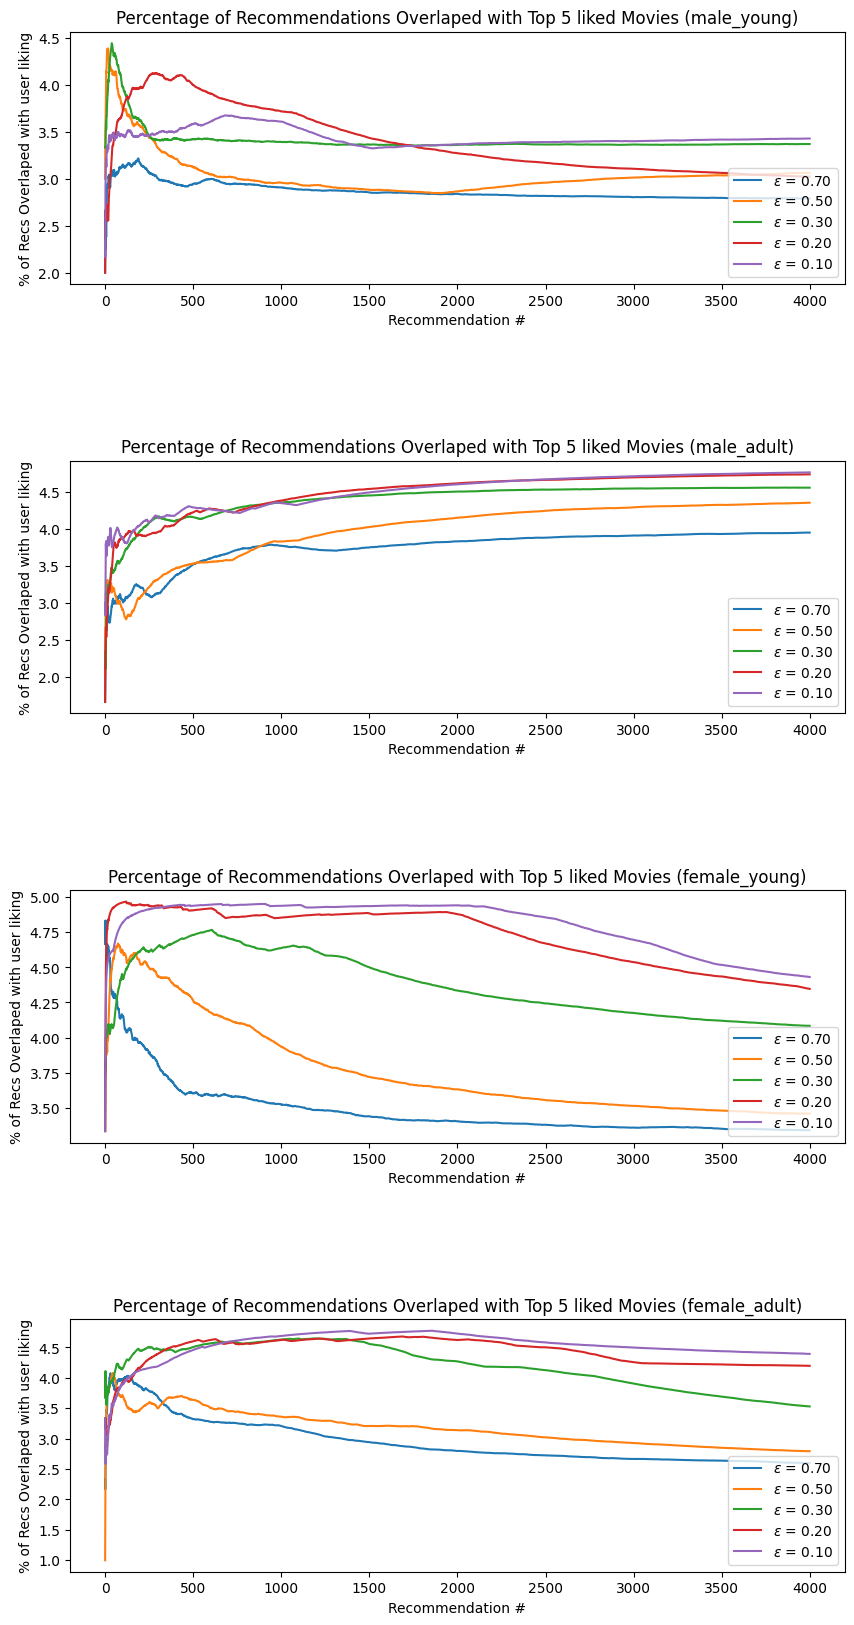

In [12]:

from matplotlib import pyplot as plt
import pandas as pd

fig, ax = plt.subplots(4,1, figsize=(10,20),squeeze=False)
reward_history_list_name = ['male_young','male_adult','female_young','female_adult']
epsilon_values = [0.7,0.5,0.3,0.2,0.1]

for i in range(len(reward_history_list_name)):
    result_df_list = []
    result_avg_df_list = []
    focal_group = reward_history_list_name[i]
    for epsilon in epsilon_values:
        df = pd.read_csv(f'output_MAB/{focal_group}_e={epsilon}.csv', index_col=0)
        result_df_list.append(df)
        result_avg_df_list.append(df.groupby('visit',as_index=False).mean())
        
    

    for avg_results_df in result_avg_df_list:
        ax[i,0].plot(avg_results_df.visit, avg_results_df['fraction_relevant'], linewidth=1.5)

    ax[i,0].set_title(f'Percentage of Recommendations Overlaped with Top 5 liked Movies ({focal_group})')
    ax[i,0].set_xlabel('Recommendation #')
    ax[i,0].set_ylabel('% of Recs Overlaped with user liking')

    ax[i,0].legend([
            '$\epsilon$ = 0.70',
            '$\epsilon$ = 0.50',
            '$\epsilon$ = 0.30',
            '$\epsilon$ = 0.20',
            '$\epsilon$ = 0.10',
            ],
            loc='lower right'
            )
plt.subplots_adjust(hspace=0.7)
plt.show()

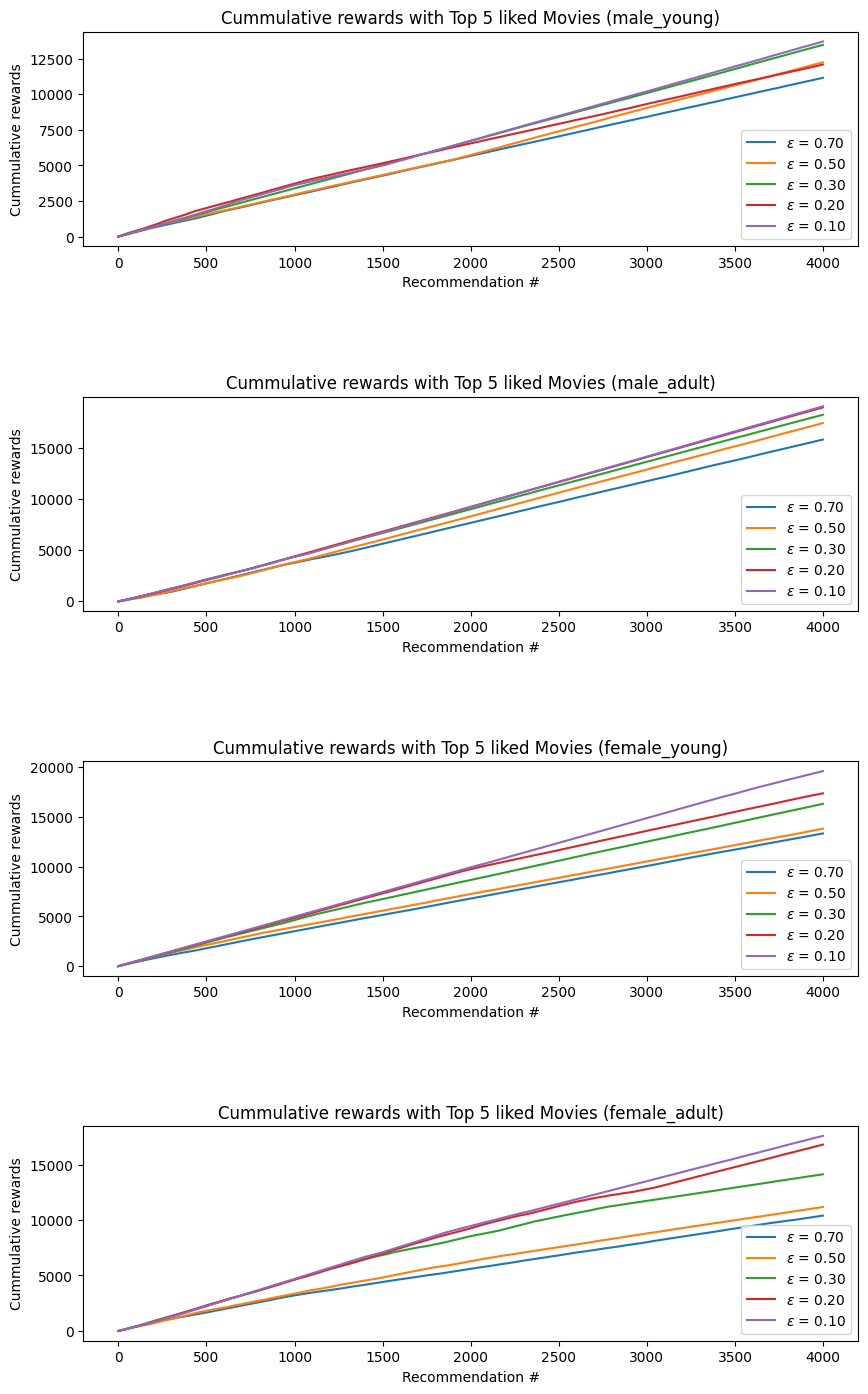

In [11]:
fig, ax = plt.subplots(4,1, figsize=(10,17),squeeze=False)
for i in range(len(reward_history_list_name)):
    result_df_list = []
    result_avg_df_list = []
    focal_group = reward_history_list_name[i]
    for epsilon in epsilon_values:
        df = pd.read_csv(f'output_MAB/{focal_group}_e={epsilon}.csv', index_col=0)
        result_df_list.append(df)
        result_avg_df_list.append(df.groupby('visit',as_index=False).mean())
        
    

    for avg_results_df in result_avg_df_list:
        ax[i,0].plot(avg_results_df.visit, avg_results_df['total_reward'], linewidth=1.5)

    ax[i,0].set_title(f'Cummulative rewards with Top 5 liked Movies ({focal_group})')
    ax[i,0].set_xlabel('Recommendation #')
    ax[i,0].set_ylabel('Cummulative rewards')

    ax[i,0].legend([
            '$\epsilon$ = 0.70',
            '$\epsilon$ = 0.50',
            '$\epsilon$ = 0.30',
            '$\epsilon$ = 0.20',
            '$\epsilon$ = 0.10',
            ],
            loc='lower right'
            )
plt.subplots_adjust(hspace=0.7)
plt.show()

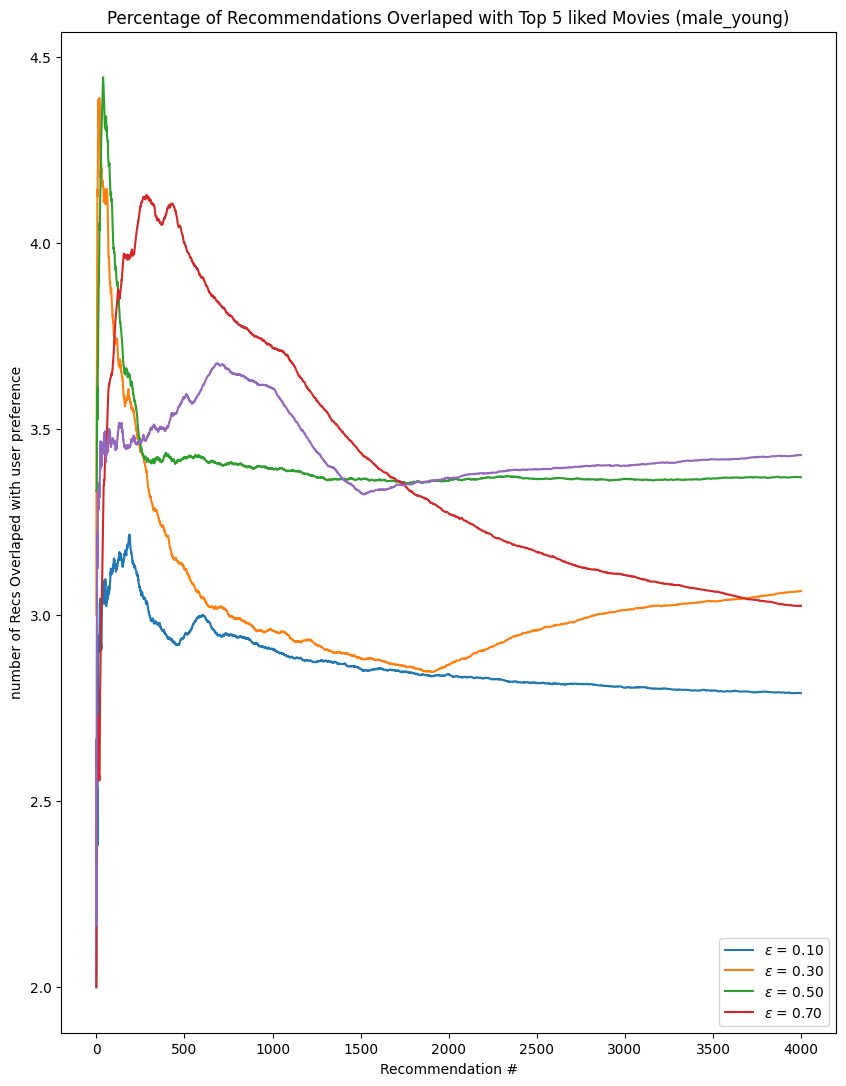

In [16]:

fig, ax = plt.subplots(figsize=(10,13))
result_df_list = []
result_avg_df_list = []
for epsilon in epsilon_values:
        df = pd.read_csv(f'output_MAB/male_young_e={epsilon}.csv', index_col=0)
        result_df_list.append(df)
        result_avg_df_list.append(df.groupby('visit',as_index=False).mean())
        
    

for avg_results_df in result_avg_df_list:
    ax.plot(avg_results_df.visit, avg_results_df['fraction_relevant'], linewidth=1.5)

ax.set_title(f'Percentage of Recommendations Overlaped with Top 5 liked Movies (male_young)')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('number of Recs Overlaped with user preference')

ax.legend([
        '$\epsilon$ = 0.10',
        '$\epsilon$ = 0.30',
        '$\epsilon$ = 0.50',
        '$\epsilon$ = 0.70',
        ],
        loc='lower right'
        )